In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import nngls
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def f5(X): return (10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2]-0.5)**2 + 10*X[:,3] +5*X[:,4])/6

sigma = 1
phi = 3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 5; funXY = f5

n = 1000
nn = 20
batch_size = 50

X, Y, coord, cov, corerr = nngls.Simulation(n, p, nn, funXY, theta, range=[0, 1])

data = nngls.make_graph(X, Y, coord, nn)

data_train, data_val, data_test = nngls.split_data(X, Y, coord, neighbor_size = 20, 
                                                   test_proportion = 0.2)


In [7]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(p, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1)
)
nn_model = nngls.nn_train(mlp, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)
nngls.theta_update(torch.tensor([1, 1.5, 0.01]), mlp(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp = torch.nn.Sequential(
    torch.nn.Linear(p, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1)
)
model = nngls.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp, theta=torch.tensor([1.5, 5, 0.1]))
nngls_model = nngls.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 10, Update_step = 10)

0
1
2
3
4
INFO: Early stopping counter 1 of 10
5
INFO: Early stopping counter 2 of 10
6
7
8
9
INFO: Early stopping counter 1 of 10
10
11
12
13
14
15
16
17
18
19
20
21
INFO: Early stopping counter 1 of 10
22
23
24
INFO: Early stopping counter 1 of 10
25
26
27
28
INFO: Early stopping counter 1 of 10
29
INFO: Early stopping counter 2 of 10
30
INFO: Early stopping counter 3 of 10
31
32
INFO: Early stopping counter 1 of 10
33
INFO: Early stopping counter 2 of 10
34
INFO: Early stopping counter 3 of 10
35
INFO: Early stopping counter 4 of 10
36
INFO: Early stopping counter 5 of 10
37
Epoch 00038: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping counter 6 of 10
38
INFO: Early stopping counter 7 of 10
39
INFO: Early stopping counter 8 of 10
40
INFO: Early stopping counter 9 of 10
41
INFO: Early stopping counter 10 of 10
INFO: Early stopping
End at epoch41
Theta updated from
[1.   1.5  0.01]


/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


0
1
2
3
4
5
6
INFO: Early stopping counter 1 of 10
7
INFO: Early stopping counter 2 of 10
8
INFO: Early stopping counter 3 of 10
9
INFO: Early stopping counter 4 of 10
10
Theta updated from
[1.5 5.  0.1]


/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


to
[0.88030713 7.51524864 0.14899461]
INFO: Early stopping counter 5 of 10
11
12
INFO: Early stopping counter 1 of 10
13
14
15
INFO: Early stopping counter 1 of 10
16
INFO: Early stopping counter 2 of 10
17
18
INFO: Early stopping counter 1 of 10
19
INFO: Early stopping counter 2 of 10
20
Theta updated from
[0.88030714 7.515249   0.14899461]


/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


to
[0.71642244 9.60102715 0.17940453]
INFO: Early stopping counter 3 of 10
21
INFO: Early stopping counter 4 of 10
22
INFO: Early stopping counter 5 of 10
23
Epoch 00024: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping counter 6 of 10
24
INFO: Early stopping counter 7 of 10
25
INFO: Early stopping counter 8 of 10
26
INFO: Early stopping counter 9 of 10
27
INFO: Early stopping counter 10 of 10
INFO: Early stopping
End at epoch27


In [14]:
# Compute benchmark MSE (always predicting the mean)
benchmark_preds = torch.full(data_test.y.shape, data_train.y.mean())
benchmark_mse = torch.nn.functional.mse_loss(benchmark_preds, data_test.y)
print(f'Benchmark MSE: {benchmark_mse:.3f}')

Benchmark MSE: 1.248


In [37]:
mlp = torch.nn.Sequential(
            torch.nn.Linear(p, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1)
        )
model = nngls.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp = mlp, theta = torch.tensor([1.5, 5, 0.1]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
Update_init = 0; Update_step = 1; Update_bound = 0.1; patience_half = 5; patience = 10;
lr_scheduler = nngls.LRScheduler(optimizer, patience = patience_half, factor=0.5)
early_stopping = nngls.EarlyStopping(patience=patience, min_delta = 0.001)

training_log = {'val_loss': [], 'pred_loss': [], 'sigma': [], 'phi': [], 'tau': []}

# Training/evaluation loop
start_time = time.time()
for epoch in range(100):
    # Train for one epoch
    model.train()
    if (epoch >= Update_init) & (epoch % Update_step == 0):
        model.theta.requires_grad = True
    else:
        model.theta.requires_grad = False
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        decorrelated_preds, decorrelated_targets, est = model(batch)
        loss = torch.nn.functional.mse_loss(decorrelated_preds[:batch_size], decorrelated_targets[:batch_size])
        metric = torch.nn.functional.mse_loss(est[:batch_size], batch.y[:batch_size])
        loss.backward()
        optimizer.step()
    # Compute predictions on held-out test test
    model.eval()
    _, _, val_est = model(data_val)
    val_loss = torch.nn.functional.mse_loss(val_est, data_val.y).item()
    lr_scheduler(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print('End at epoch' + str(epoch))
        break
    _, _, pred_test = model(data_test)
    pred_loss = torch.nn.functional.mse_loss(pred_test, data_test.y).item()
    training_log["val_loss"].append(val_loss)
    training_log["pred_loss"].append(pred_loss)
    training_log["sigma"].append(model.theta[0].item())
    training_log["phi"].append(model.theta[1].item())
    training_log["tau"].append(model.theta[2].item())
end_time = time.time()

INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
I

In [8]:
print(f"\rRunning time: {end_time - start_time} seconds")

NameError: name 'end_time' is not defined

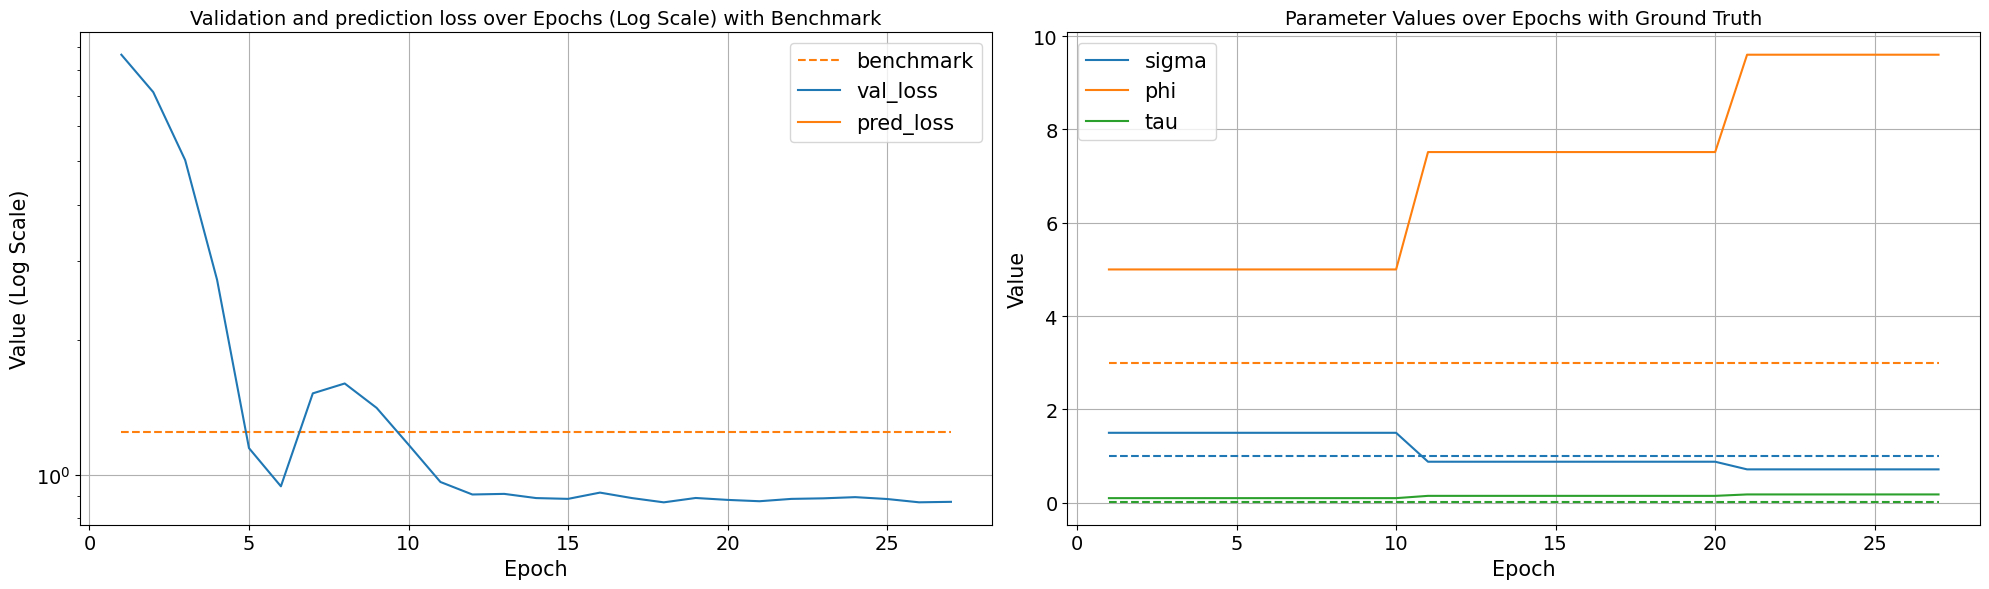

In [16]:
epoch = len(training_log["val_loss"])
training_log["epoch"] = list(range(1, epoch + 1))
training_log["pred_loss"] = None
training_log = pd.DataFrame(training_log)

# Melting the dataframe to make it suitable for seaborn plotting
training_log_melted = training_log[["epoch", "val_loss", "pred_loss"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')

# Finding the color used for the 'metric' in the plot
palette = sns.color_palette()
metric_color = palette[1]  # Assuming 'metric' is the second line in the plot

# Plotting with seaborn
# Creating two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
benchmark_line = axes[0].hlines(y=benchmark_mse, xmin=1, xmax=epoch, color=metric_color, linestyle='--', label='benchmark')
sns.lineplot(ax=axes[0], data=training_log_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)

axes[0].set_title('Validation and prediction loss over Epochs (Log Scale) with Benchmark', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Value (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)

# Second plot (sigma, phi, tau)
kernel_params_melted = training_log[["epoch", "sigma", "phi", "tau"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')
ground_truth = {'sigma': sigma, 'phi': phi, 'tau': tau}
sns.lineplot(ax=axes[1], data=kernel_params_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)
palette = sns.color_palette()
for i, (param, gt_value) in enumerate(ground_truth.items()):
    axes[1].hlines(y=gt_value, xmin=1, xmax=epoch, color=palette[i], linestyle='--')
axes[1].set_title('Parameter Values over Epochs with Ground Truth', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('Value', fontsize=15)
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)

plt.tight_layout()

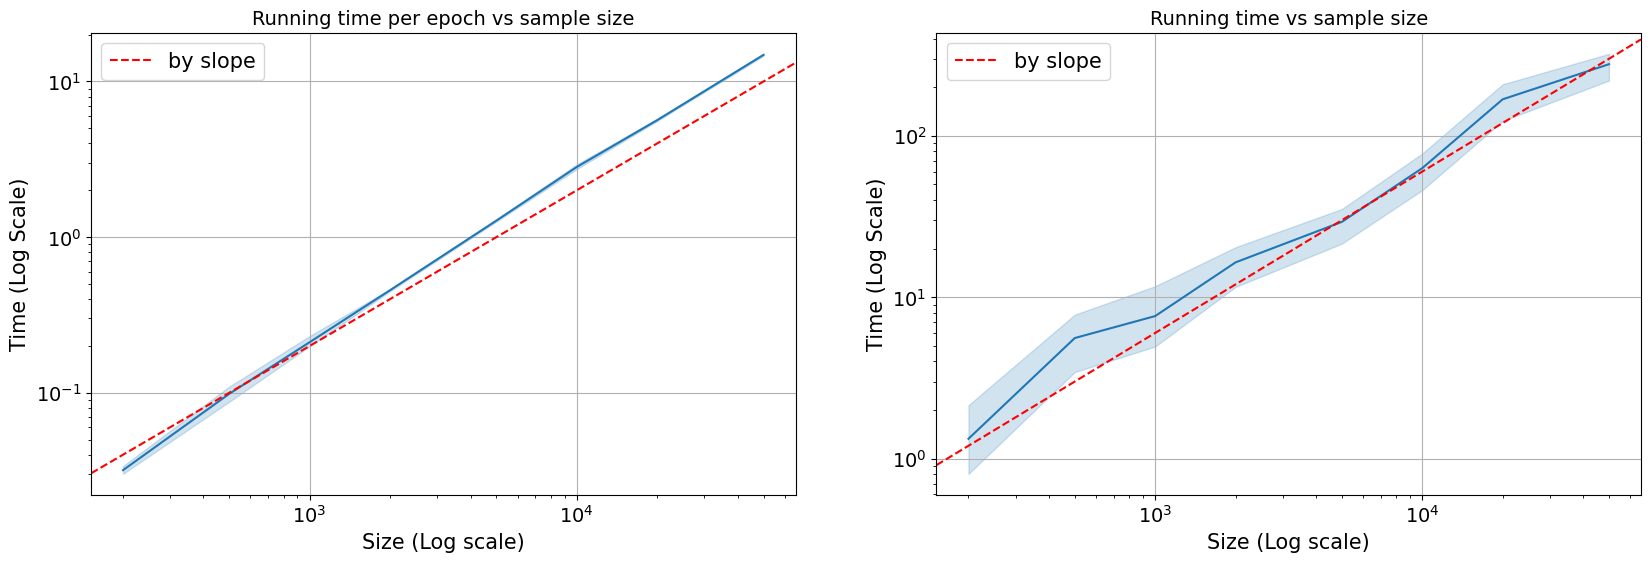

In [17]:
time = pd.read_csv("./running_time.csv")
time['Time per epoch'] = time['time']/time['epoch']

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.lineplot(ax=axes[0], data=time, x='size', y='Time per epoch', markers=False, dashes=False)
axes[0].set_title('Running time per epoch vs sample size', fontsize=14)
axes[0].axline((200, 0.04), slope=1, color='red', label='by slope', linestyle='--')
axes[0].set_xlabel('Size (Log scale)', fontsize=15)
axes[0].set_ylabel('Time (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)

sns.lineplot(ax=axes[1], data=time, x='size', y='time', markers=False, dashes=False)
axes[1].set_title('Running time vs sample size', fontsize=14)
axes[1].axline((200, 1.2), slope=1, color='red', label='by slope', linestyle='--')
axes[1].set_xlabel('Size (Log scale)', fontsize=15)
axes[1].set_ylabel('Time (Log Scale)', fontsize=15)
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)
#axes[1].set_yscale('log')